## 1. 데이터 로드하기

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

try:
  from konlpy.tag import Okt
except ModuleNotFoundError:
  !pip install konlpy
  from konlpy.tag import Okt

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7faafc001080>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
train_data[:5] # 상위 5개 출력
print(train_data[:5])

훈련용 리뷰 개수 : 150000
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


In [4]:
news_data = pd.read_csv('/content/news_result.csv', encoding="utf-8-sig")

In [5]:
from pandas import DataFrame

news_data = pd.read_csv('/content/news_label_preprocess.csv')
news_train = news_data[:1100]
news_test = news_data[1100:]

news_train_combine = {"id":[],
                      "document":[],
                      "label":[]
                     }

news_train_combine["id"] = [x for x in range(1100)]
news_train_combine["document"] = news_train["Summary"]
news_train_combine["label"] = news_train["Label"]
fin_news_train = DataFrame(news_train_combine)


news_test_combine = {"id":[],
                     "document":[],
                     "label":[]
                     }
news_test_combine["id"] = [x for x in range(1100, len(news_data))]                                           
news_test_combine["document"] = news_test["Summary"]
news_test_combine["label"] = news_test["Label"]
fin_news_test = DataFrame(news_test_combine)

train_data = pd.concat([train_data,fin_news_train])
test_data = pd.concat([test_data,fin_news_test])

print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('훈련용 리뷰 개수 :',len(test_data)) # 훈련용 리뷰 개수 출력



훈련용 리뷰 개수 : 151100
훈련용 리뷰 개수 : 50520


## 2. 데이터 정제하기

147253 3
49676 3
   label  count
0   -1.0    312
1    0.0  73658
2    1.0  73284
   label  count
0   -1.0    187
1    0.0  24590
2    1.0  24900


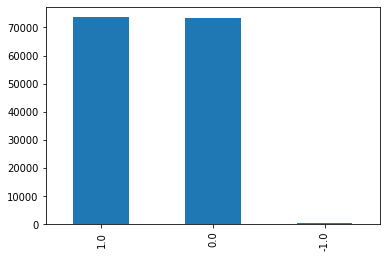

In [6]:
# Unique 데이터 확인하기
print(train_data['document'].nunique(), train_data['label'].nunique())
print(test_data['document'].nunique(), test_data['label'].nunique())

# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True) 
test_data.drop_duplicates(subset=['document'], inplace=True) 

# Data 막대 그래프로 그리기
train_data['label'].value_counts().plot(kind = 'bar')
test_data['label'].value_counts().plot(kind = 'bar')

# 라벨 사이즈 체크하기
print(train_data.groupby('label').size().reset_index(name = 'count'))
print(test_data.groupby('label').size().reset_index(name = 'count'))

In [7]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'].replace('', np.nan, inplace=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0.0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1.0
2,10265843,너무재밓었다그래서보는것을추천한다,0.0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0.0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1.0


In [8]:
# 한글과 공백을 제외하고 모두 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'].replace('', np.nan, inplace=True)
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1.0
1,9274899,NaN,0.0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0.0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0.0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0.0


In [9]:
# Null값 확인하기
if train_data.isnull().values.any():
  print(train_data.isnull().sum())
  print()

  # Null 값 제거하기
  train_data = train_data.dropna(how = "any")

  # Null 값 있는지 다시 한 번 확인
  print(train_data.isnull().sum())

# Null값 확인하기
if test_data.isnull().values.any():
  print(test_data.isnull().sum())
  print()

  # Null 값 제거하기
  test_data = test_data.dropna(how = "any")

  # Null 값 있는지 다시 한 번 확인
  print(test_data.isnull().sum())

id            0
document    392
label         0
dtype: int64

id          0
document    0
label       0
dtype: int64
id            0
document    163
label         0
dtype: int64

id          0
document    0
label       0
dtype: int64


In [10]:
# document 열에서 중복인 내용 한 번 더 제거
train_data.drop_duplicates(subset=['document'], inplace=True) 
test_data.drop_duplicates(subset=['document'], inplace=True) 

In [11]:
# 전처리 후 데이터의 변화
print(len(train_data))
print(len(test_data))

144752
48936


## 3. 토큰화

In [12]:
# 불용어 리스트
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [13]:
okt = Okt()
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [14]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
print(X_test[:3])

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


## 4. 정수 인코딩

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '되다': 10, '정말': 11, '적': 12, '만': 13, '재밌다': 14, '로': 15, '같다': 16, '진짜': 17, '않다': 18, '아니다': 19, '에서': 20, '점': 21, '것': 22, '나오다': 23, '만들다': 24, '연기': 25, '평점': 26, '내': 27, '인': 28, '그': 29, '최고': 30, '나': 31, '안': 32, '못': 33, '스토리': 34, '생각': 35, '왜': 36, '드라마': 37, '게': 38, '사람': 39, '감동': 40, '보고': 41, '고': 42, '말': 43, '이렇다': 44, '더': 45, '아깝다': 46, '때': 47, '배우': 48, 'ㅋㅋ': 49, '아': 50, '감독': 51, '중': 52, '거': 53, '그냥': 54, '요': 55, '까지': 56, '재미있다': 57, '수': 58, '하고': 59, '시간': 60, '내용': 61, '재미': 62, '주다': 63, '뭐': 64, '자다': 65, '지루하다': 66, '네': 67, '재미없다': 68, '쓰레기': 69, '가다': 70, '들다': 71, '모르다': 72, '지': 73, '그렇다': 74, '싶다': 75, '작품': 76, '알다': 77, '사랑': 78, '하나': 79, '다시': 80, '마지막': 81, '볼': 82, '일': 83, '오다': 84, '저': 85, '정도': 86, '이건': 87, '많다': 88, '완전': 89, 'ㅋ': 90, '처음': 91, 'ㅠㅠ': 92, 'ㅋㅋㅋ': 93, '장면': 94, '개': 95, '년': 96, '액션': 97, '주인공': 98, '이렇게': 99, '걸': 100, '안되다': 101, '차다': 10

In [16]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45627
등장 빈도가 2번 이하인 희귀 단어의 수: 24894
단어 집합에서 희귀 단어의 비율: 54.55980011835098
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8115148441609583


In [17]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 20735


In [18]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])

[[51, 480, 18, 273, 690], [1011, 481, 42, 632, 2, 220, 1544, 26, 1018, 715, 19], [402, 2679, 1, 2182, 6017, 3, 227, 10]]


In [19]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 5. 빈 샘플 제거

In [20]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

144722
144722


## 6. 패딩

리뷰의 최대 길이 : 882
리뷰의 평균 길이 : 11.704032558975138


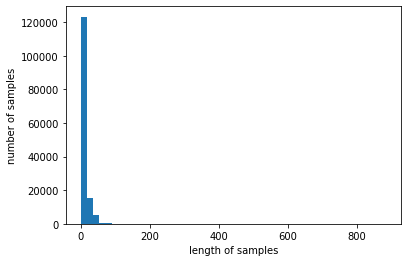

In [21]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [23]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 93.35691878221694


In [24]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 7. LSTM 모델 만들기

In [25]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [26]:
# 임베딩 벡터의 차원은 100으로 정했고, 리뷰 분류를 위해서 LSTM을 사용
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [27]:
# 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [28]:
# 에포크는 총 100번을 수행 / 훈련 데이터 중 20%를 검증 데이터로 사용하면서 정확도를 확인합니다.
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/100
1927/1930 [============================>.] - ETA: 0s - loss: 0.3927 - acc: 0.8219
Epoch 00001: val_acc improved from -inf to 0.82398, saving model to best_model.h5
1930/1930 [==============================] - 27s 14ms/step - loss: 0.3926 - acc: 0.8220 - val_loss: 0.3686 - val_acc: 0.8240
Epoch 2/100
1927/1930 [============================>.] - ETA: 0s - loss: 0.3305 - acc: 0.8554
Epoch 00002: val_acc improved from 0.82398 to 0.83531, saving model to best_model.h5
1930/1930 [==============================] - 26s 14ms/step - loss: 0.3304 - acc: 0.8554 - val_loss: 0.3553 - val_acc: 0.8353
Epoch 3/100
1927/1930 [============================>.] - ETA: 0s - loss: 0.3049 - acc: 0.8698
Epoch 00003: val_acc improved from 0.83531 to 0.83890, saving model to best_model.h5
1930/1930 [==============================] - 26s 13ms/step - loss: 0.3048 - acc: 0.8698 - val_loss: 0.3529 - val_acc: 0.8389
Epoch 4/100
1929/1930 [============================>.] - ETA: 0s - loss: 0.2847 - acc: 0.88

In [29]:
loaded_model = load_model('/content/best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1530/1530 [==============================] - 5s 3ms/step - loss: 0.3402 - acc: 0.8497

 테스트 정확도: 0.8497


## 7. Prediction

In [54]:
def sentiment_predict(new_sentence):
  print(new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [55]:
sentiment_predict("뉴욕증시가 2018년 마지막 거래일에도 오르며 크리스마스 이후 막판 상승세를 이어갔다. 하지만 3대 주요 지수는 연간 3~6%대 하락하며 2008년 금융위기 이후 최악의 연간 상승률을 기록했다. 월가 전문가들은 뉴욕증시가 내년초 상승세를 보일 수 있지만, 추가적인 바닥다지기 과정을 필요로 할 것이라고 진단했다. 랠리를 위해서는 구체적인 촉매제가 필요하며 연방정부 셧다운, 미중간 무역협상 등 불확실성들에 대한 경계감을 가져야한다는 지적이다. 31일(현지시간) 다우존스산업평균지수는 전일대비 265.06포인트(1.2%) 상승한 2만3327.46으로 거래를 마쳤다. S&P500지수는 전일대비 21.11포인트(0.9%) 오른 2506.85로 장을 끝냈다. 기술주 중심의 나스닥종합지수는 6635.28로 전일대비 50.76포인트(0.8%) 올랐다. 제프 디그라프 르네상스매크로리서치 회장은 새해 첫 2~3주간을 전망해보면 시장이 궁극적으로 이 약세장에서 다음 단계로 나아가기 전에 극단적인 심리들이 완화되고, 낙관론을 다시 회복하면서 더 상승할 것으로 믿는다 고 전망했다. 콜린 시에진스키 SIA자산관리 최고시장전략가는 윈도드레싱과 저가매수세가 무역관련 호재와 함께 시장에 상승 동력을 제공했다 며 일단 새해에 미 연방정부 셧다운(일시적 업무정지)이 끝나면 증시가 추가 상승을 위한 시험을 받을 것 이라고 내다봤다. 존 스톨츠퍼스 오펜하이머자산관리 최고투자전략가는 올해 증시 하락으로 2019년 상승 서프라이즈를 위한 무대가 준비되고 있다 며 주가수익비율이 지난 3분기말 수준으로 돌아가는 기회를 얻을 수 있다“고 분석했다. 하지만 그는 2019년 1분기까지 매우 중대한 랠리가 나타날 것으로는 기대하기 어렵다“며 랠리를 위한 구체적인 중요성을 가진 촉매제가 나타날 때까지 새해에도 시장 위험이 투자심리에 압박할 것 이라고 강조했다.")

뉴욕증시가 2018년 마지막 거래일에도 오르며 크리스마스 이후 막판 상승세를 이어갔다. 하지만 3대 주요 지수는 연간 3~6%대 하락하며 2008년 금융위기 이후 최악의 연간 상승률을 기록했다. 월가 전문가들은 뉴욕증시가 내년초 상승세를 보일 수 있지만, 추가적인 바닥다지기 과정을 필요로 할 것이라고 진단했다. 랠리를 위해서는 구체적인 촉매제가 필요하며 연방정부 셧다운, 미중간 무역협상 등 불확실성들에 대한 경계감을 가져야한다는 지적이다. 31일(현지시간) 다우존스산업평균지수는 전일대비 265.06포인트(1.2%) 상승한 2만3327.46으로 거래를 마쳤다. S&P500지수는 전일대비 21.11포인트(0.9%) 오른 2506.85로 장을 끝냈다. 기술주 중심의 나스닥종합지수는 6635.28로 전일대비 50.76포인트(0.8%) 올랐다. 제프 디그라프 르네상스매크로리서치 회장은 새해 첫 2~3주간을 전망해보면 시장이 궁극적으로 이 약세장에서 다음 단계로 나아가기 전에 극단적인 심리들이 완화되고, 낙관론을 다시 회복하면서 더 상승할 것으로 믿는다 고 전망했다. 콜린 시에진스키 SIA자산관리 최고시장전략가는 윈도드레싱과 저가매수세가 무역관련 호재와 함께 시장에 상승 동력을 제공했다 며 일단 새해에 미 연방정부 셧다운(일시적 업무정지)이 끝나면 증시가 추가 상승을 위한 시험을 받을 것 이라고 내다봤다. 존 스톨츠퍼스 오펜하이머자산관리 최고투자전략가는 올해 증시 하락으로 2019년 상승 서프라이즈를 위한 무대가 준비되고 있다 며 주가수익비율이 지난 3분기말 수준으로 돌아가는 기회를 얻을 수 있다“고 분석했다. 하지만 그는 2019년 1분기까지 매우 중대한 랠리가 나타날 것으로는 기대하기 어렵다“며 랠리를 위한 구체적인 중요성을 가진 촉매제가 나타날 때까지 새해에도 시장 위험이 투자심리에 압박할 것 이라고 강조했다.
80.45% 확률로 부정 리뷰입니다.



In [53]:
sentiment_predict('미중 무역협상 기대에 31일 다우 1.15% 상승 마감증시 10년 강세장 마감 속 12월 최악 기록도 속출[서울경제] 미국 뉴욕증시의 주요 지수는 올 해 마지막 날인 31일(현지시간) 미국과 중국 간 무역협상 기대감에 상승했지만 10년 강세장을 마감하며 12월 수익률은 최악의 기록이 속출했다. 다우존스산업평균지수는 이날 뉴욕증권거래소(NYSE)에서 265.06포인트(1.15%) 상승한 23,327.46에 거래를 마쳤다.스탠더드앤드푸어스(S&P) 500 지수는 21.11포인트(0.85%) 오른 2,506.85에, 기술주 중심의 나스닥 지수는 50.76포인트(0.77%) 상승한 6,635.28에 장을 마감했다.다우지수와 S&P500지수의 12월 하락률은 8.7%, 9.2%로 1931년 이후 가장 나빴다. 나스닥지수는 9.5% 하락해 2002년 이후 최악의 12월을 보냈다.올해 다우지수와 S&P지수, 나스닥지수는 각각 5.6%, 6.2%, 3.9% 떨어졌다. 이들 지수 모두 2008년 이후 연간으로 가장 많이 떨어졌다. 금융위기 한파가 몰아치던 2008년에 뉴욕 증시의 3대 지수는 30~40% 급락했다. 2008년 글로벌 금융위기 이후로는 최악의 성적표를 내면서 ‘10년 강세장’에도 마침표를 찍었다는 것이 월가의 대체적인 평가다. S&P500지수와 다우지수는 3년 만에 처음으로 하락했으며 나스닥지수는 6년 연속 상승세를 올해 멈췄다. 특히 올해는 주요 지수가 잇따라 사상 최고치를 찍은 뒤 가파르게 떨어지는 등 극심한 변동성 장세를 나타냈다. 뉴욕증권거래소지난주 극심한 변동성을 보인 증시는 2018년 마지막 거래일을 맞아 장 초반부터 안정세를 보였다. 미국과 중국의 무역협상 타결 가능성을 엿보게 하는 소식들이 전해진 영향으로 위험자산 선호 심리가 살아났다.트럼프 대통령은 지난 29일 트위터를 통해 “방금 중국 시 주석과 길고 매우 좋은 통화를 했다. 협상은 아주 잘 진행되고 있다”면서 “큰 진전이 이뤄지고 있다!”고 말했다.시진핑 주석도 “나와 트럼프 대통령은 중미 관계를 안정적인 방향으로 추진하는 데 동의했다”면서 “현재 양국 관계는 중요한 단계에 있다”고 설명했다. 미·중 무역협상단은 통상갈등을 해소하기 위해 내년 1월 7일부터 중국 베이징에서 협상에 들어갈 것으로 전해졌다.다만 새해까지 계속될 것으로 보이는 미국 연방정부의 부문 폐쇄인 셧다운과 2년래 최저치를 기록한 중국 제조업 지표 악화 등에 따른 글로벌 경기 둔화 우려는 여전했다.종목별로는 머크가 1% 이상 올랐다. 머크는 올해 다우지수 30개 종목 중 가장 좋은 성적을 냈다. 화이자 역시 1.6% 상승했다. 넷플릭스가 4.5% 오르고, 아마존이 1% 상승하는 등 주요 기술주도 상승세를 나타냈다. 증시 전문가들은 내년 증시에 대한 기대를 점차 키우고 있다. 존 스톨츠퍼스 오펜하이머에셋의 수석 투자전략가는 “최근 하락으로 내년 깜짝 상승을 위한 무대가 만들어지고 있다”며 “내년 3분기 말에는 기존 밸류에이션 수준으로 복귀할 기회가 있을 것”이라고 말했다.시카고옵션거래소(CBOE)에서 변동성지수(VIX)는 10.37% 하락한 25.40을 기록했다. ')

['밉다', '중', '무역', '협상', '기대', '31일', '다우', '1.15%', '상승', '마감', '증시', '10년', '강세', '장', '마감', '속', '12월', '최악', '기록', '속출', '[', '서울', '경제', ']', '미국', '뉴욕증시', '주요', '지수', '오다', '해', '마지막', '날인', '31일', '(', '현지', '시간', ')', '미국', '중국', '간', '무역', '협상', '기', '대감', '상승', '10년', '강세', '장', '을', '마감', '12월', '수익률', '최악', '기록', '속출', '.', '다우존스', '산업', '평균', '지수', '날', '뉴욕', '증권', '거래소', '(', 'NYSE', ')', '에서', '265.06', '포인트', '(', '1.15%', ')', '상승', '23,327.46', '거래', '마치다', '.', '스탠더드', '앤드', '푸다', '어스', '(', 'S', '&', 'P', ')', '500', '지수', '21.11', '포인트', '(', '0.85%', ')', '오른', '2,506.85', ',', '기술', '주', '중심', '나스닥', '지수', '50.76', '포인트', '(', '0.77%', ')', '상승', '6,635.28', '장', '을', '마감', '.', '다우지수', 'S', '&', 'P', '500', '지수', '12월', '하락', '률', '8.7%', ',', '9.2%', '로', '1931년', '이후', '가장', '나쁘다', '.', '나스닥', '지수', '9.5%', '하락', '2002년', '이후', '최악', '12월', '을', '보내다', '.', '올해', '다우지수', 'S', '&', 'P', '지수', ',', '나스닥', '지수', '각각', '5.6%', ',', '6.2%', ',', '3.9%', '떨어지다', '.',

In [50]:
sentiment_predict("中 주식형펀드 설정액 석달 새 326억원 증가베트남·인도펀드도 순유입상반기 낙폭 만회 기대감 추세 반전 가능성은 '글쎄'[ 마지혜 기자 ] 지난해 급락한 신흥국 증시의 반등에 베팅하는 투자자가 늘고 있다. 미국 중앙은행(Fed)이 기준금리 인상 속도를 늦춰 신흥국 유동성에 숨통이 트일 것이란 기대 등에 따른 것이다.2일 펀드평가사 에프앤가이드에 따르면 국내 설정된 중국 주식형 펀드 166개의 설정액은 지난해 12월 44억원 늘었다. 지난해 10월 이후 석 달간 326억원 증가했다. 베트남 주식형 펀드와 인도 주식형 펀드에도 지난달 각각 124억원과 34억원의 자금이 들어왔다. 선진국인 미국 펀드의 설정액이 385억원 줄고, 유럽과 일본 펀드에서도 각각 226억원과 88억원이 빠져나간 것과 대조적이다.지난해 MSCI신흥국지수는 16.9% 떨어졌다. 미국 S&P500지수(-7.03%), 유로스톡스600지수(-13.61%)에 비해 낙폭이 컸다. 투자자들의 신흥국 펀드 매수세는 지난해 선진국에 비해 크게 떨어진 신흥국 증시가 올해 상반기 일부 낙폭을 만회할 것이란 기대가 작용하고 있다는 해석이다.미국의 금리 인상 속도 조절과 미·중 무역분쟁 완화 등에 대한 시장의 기대도 신흥국 투자심리에 온기를 지피고 있다. 김승한 유화증권 연구원은 “신흥국 증시를 압박한 요인들이 지난해 말부터 완화되고 있어 선진국에 비해 조정을 많이 받은 신흥국 증시가 연초 반등을 시도할 가능성이 있다”고 전망했다.하지만 전문가들은 신흥국 증시의 추세적 상승 가능성에 대해선 물음표를 찍는 분위기다. 유승민 삼성증권 연구원은 “신흥 시장이 미래 우려와 위험을 이미 반영한 수준으로 하락해 단기 반등할 가능성이 있다는 데는 동의한다”면서도 “올해는 미국과 중국을 포함해 전 세계 경기가 둔화되는 국면이기 때문에 신흥국의 수출과 기업 실적이 부진할 것이란 전망을 직시해야 한다”고 말했다.IBK투자증권은 신흥국 주식을 올해 주요 자산 중 가장 매력이 떨어지는 자산으로 꼽았다. 글로벌 유동성이 지난해보다 더 위축되면서 신흥국 주식을 압박할 것이라는 진단이다. 작년엔 미국과 영국을 중심으로 통화정책 정상화가 진행됐지만 올해는 유럽과 일본도 합세할 예정이기 때문이다. 박옥희 IBK투자증권 연구원은 “선진국 통화정책 정상화에 따른 자금유출, 보호무역 확산에 따른 교역증가율 둔화, 중국의 경제성장세 약화 등이 신흥국 경제와 증시에 부담을 줄 것”이라고 말했다.")

59.12% 확률로 부정 리뷰입니다.



In [56]:
test = pd.read_csv("/content/SK_news_summary.csv", encoding='utf-8-sig')
test_data = test["Summary"].to_list()

for data in test_data:
  sentiment_predict(data)

안재용 사장은 지난달 "국내 코로나19 백신 개발을 위한 기술과 생산에 대해 글로벌 기업뿐 아니라 국제기구에서도 주목하고 있다"면서 "자체 백신 개발뿐 아니라 해외 수입 등 투트랙 전략의 정부 정책에도 적극 호응해 나갈 것"이라고 말했다.
27년 전 고 최종현 회장이 뿌린 바이오 씨앗, 그룹 주력으로 그는 1973년 11월 자신의 형인 최종건 창업회장이 타계한 후 그룹을 맡았다.
63.40% 확률로 부정 리뷰입니다.

현대차 초고수 매수 1위 올라 알서포트, 두산중공업, SK케미칼도 관심 [서울경제] 주식 초고수들은 28일 오전 증시에서 현대차를 가장 많이 사들인 것으로 나타났다.
전일 매수 상위에는 제넥신, LG화학, 카카오, 알서포트, SK케미칼 등이 이름을 올렸다.
반면 매도 상위에는 제넥신, 알서포트, SK케미칼, LG화학, 삼성SDI(006400) 등의 순으로 나타났다.
52.43% 확률로 부정 리뷰입니다.

공정경제 3법 일사천리…천문학적 비용 초래 최저임금·건보료 인상 청구서도 줄줄이 대기 정부 묵인 속 강성노조 도 넘는 요구도 발목 ‘털고 보자’ 공정위 무리한 조사관행도 도마 재계·학계, 시각 편향·정책 유연성 결핍 지적 강화된 규제 입법과 강성노조, 정부의 전방위 조사 등으로 인한 불확실성이 재계 전반을 짓누르고 있다.
57.19% 확률로 긍정 리뷰입니다.

세계 최초 설립된 AI신약 전문업체 스탠다임 송상옥 공동창업자 겸 최고실현 책임자(CTO) 한미약품,SK,HK이노엔등 10여개사와 신약공동개발 AI 신약플랫폼 보유, 세계적 기술력 평가 AI로 발굴,개발중 신약 파이프라인만 20여개 보유[이데일리 류성 기자] “인공지능(AI)을 활용한 신약개발 분야에서 국내 기업들의 노하우와 기술력은 세계 최고 수준으로 평가받고 있다.
스탠다임은 AI를 활용, 전임상 단계의 신약후보물질을 발굴하는 기술력과 노하우에서 글로벌 최고 수준을 갖춘 것으로 평가받는다.
56.11% 확률로 부정 리뷰입니다.

/ 연합뉴스 코로나19 재확산으로 방역에 필요한 의료용 장

In [35]:
df = pd.read_csv("/content/news_preprocess.csv", encoding='utf-8-sig')

title_lst = df["Summary"].to_list()
label_lst = []

for title in title_lst:
  result = sentiment_predict(title)
  label_lst.append(result)

In [36]:
df["Label"] = label_lst
df.to_csv("/content/news_result.csv", encoding='utf-8-sig')